# Part 1

In [1]:
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Download the data!

In [2]:
postal_data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")[0]

In [3]:
postal_data.head()

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
postal_data.shape

(180, 3)

### Drop the rows that contain "Not assigned" value in the 'Borough' column.

In [5]:
postal_data.drop(postal_data[ postal_data['Borough'] == "Not assigned" ].index, inplace = True)
postal_data.reset_index(drop=True, inplace=True)

In [6]:
postal_data.head()

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### Checking if theres any duplicate postal codes.

In [7]:
def check(df):
    for i in df.duplicated(subset=None, keep='first'):
        if i == True:
            return "There are duplicate postal codes!"
    return "There are no duplicate postal codes!"

check(postal_data)

'There are no duplicate postal codes!'

### Checking if a cell has a borough but a Not assigned neighborhood

In [8]:
postal_data[ postal_data['Neighborhood'] == "Not assigned"]

,Postal Code,Borough,Neighborhood


In [9]:
postal_data[ postal_data['Neighborhood'] == "NaN" ]

,Postal Code,Borough,Neighborhood


In [10]:
print("There are none!")

There are none!


In [11]:
postal_data.shape

(103, 3)

# Part 2

### Adding location data onto the data frame!

In [12]:
location_data = pd.read_csv('http://cocl.us/Geospatial_data')

In [13]:
location_data.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [14]:
location_data.shape

(103, 3)

In [15]:
postal_data = postal_data.merge(location_data)

In [16]:
postal_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


In [17]:
postal_data.shape

(103, 5)

# Part 3

In [18]:
import numpy as np

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import requests # library to handle requests

from pandas.io.json import json_normalize

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
#import folium # map rendering library

In [43]:
!pip install -U yellowbrick

     |████████████████████████████████| 266kB 8.5MB/s eta 0:00:01


In [44]:
from yellowbrick.cluster import KElbowVisualizer

In [19]:
latitude = 43.6548
longitude = -79.3883
print('The geograpical coordinate of Downtown Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Downtown Toronto are 43.6548, -79.3883.


In [20]:
downtown_data = postal_data[postal_data["Borough"] == "Downtown Toronto"]
downtown_data.reset_index(drop=True, inplace=True)
downtown_data

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M5J,Downtown Toronto,"Harbourfront East, Union Station, Toronto Islands",43.640816,-79.381752
9,M5K,Downtown Toronto,"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576


### Create a map of downtown Toronto with neighborhoods superimposed on top

In [47]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, borough, neighborhood in zip(downtown_data['Latitude'], downtown_data['Longitude'], downtown_data['Borough'], downtown_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Explore all Neighborhoods in Downtown Toronto.

In [21]:
CLIENT_ID = '0OJKA2OTGW45AMOU01BFBX2LXUOOTZIIDXMHHWXSLP4RULLK' # your Foursquare ID
CLIENT_SECRET = 'YM1JC0GXULLBKMBHU0IQ11OHBQUKLZRDEVPLB4YZGJAI5KUU' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 0OJKA2OTGW45AMOU01BFBX2LXUOOTZIIDXMHHWXSLP4RULLK
CLIENT_SECRET:YM1JC0GXULLBKMBHU0IQ11OHBQUKLZRDEVPLB4YZGJAI5KUU


In [22]:
def getNearbyVenues(names, latitudes, longitudes, query, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            query,
            100)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
            
        
        # return only relevant information for each nearby venue
        l=[]
        for v in results:
            if not v['categories'] == []:
                if query in v['categories'][0]['name'].lower():
                    l.append((name, lat, lng, v['name'], v['location']['lat'], v['location']['lng'],v['categories'][0]['name']))
       
        venues_list.append(l)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [23]:
def getNearbyVenues1(names, latitudes, longitudes, query, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&query={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            query,
            100)
            
        # make the GET request
        results = requests.get(url).json()['response']['venues']
            
        
        # return only relevant information for each nearby venue
        l=[]
        for v in results:
            if not v['categories'] == []:
                #if query in v['categories'][0]['name'].lower():
                    l.append((name, lat, lng, v['name'], v['location']['lat'], v['location']['lng'],v['categories'][0]['name']))
       
        venues_list.append(l)
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [24]:
downtown_bubbletea_venues = getNearbyVenues(names=downtown_data['Neighborhood'],
                                  latitudes=downtown_data['Latitude'],
                                  longitudes=downtown_data['Longitude'],
                                  query="bubble tea"
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [52]:
downtown_chinese_venues = getNearbyVenues1(names=downtown_data['Neighborhood'],
                                  latitudes=downtown_data['Latitude'],
                                  longitudes=downtown_data['Longitude'],
                                  query="chinese"
                                  )

Regent Park, Harbourfront
Queen's Park, Ontario Provincial Government
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Christie
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Rosedale
Stn A PO Boxes
St. James Town, Cabbagetown
First Canadian Place, Underground city
Church and Wellesley


In [53]:
downtown_bubbletea_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.654260,-79.360636,Palgong Tea,43.650090,-79.361374,Bubble Tea Shop
1,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Bubble Lee,43.665025,-79.384499,Bubble Tea Shop
2,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,琉璃鯨 The Whale Tea,43.663573,-79.384208,Bubble Tea Shop
3,"Garden District, Ryerson",43.657162,-79.378937,Happy Fruit Bubble Tea,43.656339,-79.380783,Bubble Tea Shop
4,"Garden District, Ryerson",43.657162,-79.378937,Real Fruit Bubble Tea,43.655994,-79.380577,Bubble Tea Shop


In [54]:
downtown_chinese_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Garden District, Ryerson",43.657162,-79.378937,Good View Chinese Restaurant,43.656791,-79.376139,Chinese Restaurant
1,"Garden District, Ryerson",43.657162,-79.378937,Winner BBQ Chinese Cuisine DT 贼好吃的烤肉饭,43.659320,-79.382794,Chinese Restaurant
2,"Garden District, Ryerson",43.657162,-79.378937,Yueh Tung Chinese Restaurant,43.655281,-79.385337,Chinese Restaurant
3,"Garden District, Ryerson",43.657162,-79.378937,Ho Jan 好棧粉麵小廚,43.661483,-79.381111,Chinese Restaurant
4,St. James Town,43.651494,-79.375418,Good View Chinese Restaurant,43.656791,-79.376139,Chinese Restaurant


In [56]:
downtown_bubbletea_count = downtown_bubbletea_venues.groupby(['Neighborhood']).count()[['Venue Category']]
downtown_bubbletea_count_p = downtown_bubbletea_venues.groupby(['Neighborhood']).mean()[['Neighborhood Latitude','Neighborhood Longitude']]

downtown_bubbletea_count.rename(columns={'Venue Category': 'Bubbletea Shops Count'},inplace=True)
downtown_bubbletea_count[['Latitude', 'Longitude']] = downtown_bubbletea_count_p                

In [57]:
downtown_chinese_count = downtown_chinese_venues.groupby(['Neighborhood']).count()[['Venue Category']]
downtown_chinese_count_p = downtown_chinese_venues.groupby(['Neighborhood']).mean()[['Neighborhood Latitude','Neighborhood Longitude']]

downtown_chinese_count.rename(columns={'Venue Category': 'Chinese Related Shops Count'},inplace=True)
downtown_chinese_count[['Latitude', 'Longitude']] = downtown_chinese_count_p

In [58]:
downtown_bubbletea_count

,Bubbletea Shops Count,Latitude,Longitude
Neighborhood,,,
Central Bay Street,7,43.657952,-79.387383
Church and Wellesley,9,43.665860,-79.383160
"First Canadian Place, Underground city",2,43.648429,-79.382280
"Garden District, Ryerson",8,43.657162,-79.378937
"Kensington Market, Chinatown, Grange Park",12,43.653206,-79.400049
"Queen's Park, Ontario Provincial Government",2,43.662301,-79.389494
"Regent Park, Harbourfront",1,43.654260,-79.360636
"Richmond, Adelaide, King",3,43.650571,-79.384568
"University of Toronto, Harbord",1,43.662696,-79.400049


In [59]:
downtown_chinese_count

,Chinese Related Shops Count,Latitude,Longitude
Neighborhood,,,
Central Bay Street,7,43.657952,-79.387383
Church and Wellesley,1,43.665860,-79.383160
"Commerce Court, Victoria Hotel",1,43.648198,-79.379817
"First Canadian Place, Underground city",2,43.648429,-79.382280
"Garden District, Ryerson",4,43.657162,-79.378937
"Harbourfront East, Union Station, Toronto Islands",1,43.640816,-79.381752
"Kensington Market, Chinatown, Grange Park",18,43.653206,-79.400049
"Richmond, Adelaide, King",6,43.650571,-79.384568
St. James Town,1,43.651494,-79.375418


In [60]:
postal= downtown_data
postal.set_index(postal["Neighborhood"],inplace=True)

In [61]:
l = []
ind = []
for neighborhood in downtown_data['Neighborhood']:
    if neighborhood not in downtown_bubbletea_count.index:
        l.append((0, postal.loc[neighborhood][-2], postal.loc[neighborhood][-1]))
        ind.append((neighborhood))
count = pd.DataFrame(l,index=ind)
count.rename(columns = {0:'Bubbletea Shops Count', 1:'Latitude', 2:'Longitude'},inplace = True)

In [62]:
frames = [downtown_bubbletea_count,count]
final_bubbletea_count = pd.concat(frames)
final_bubbletea_count

,Bubbletea Shops Count,Latitude,Longitude
Central Bay Street,7,43.657952,-79.387383
Church and Wellesley,9,43.665860,-79.383160
"First Canadian Place, Underground city",2,43.648429,-79.382280
"Garden District, Ryerson",8,43.657162,-79.378937
"Kensington Market, Chinatown, Grange Park",12,43.653206,-79.400049
"Queen's Park, Ontario Provincial Government",2,43.662301,-79.389494
"Regent Park, Harbourfront",1,43.654260,-79.360636
"Richmond, Adelaide, King",3,43.650571,-79.384568
"University of Toronto, Harbord",1,43.662696,-79.400049
St. James Town,0,43.651494,-79.375418


In [63]:
l = []
ind = []
for neighborhood in downtown_data['Neighborhood']:
    if neighborhood not in downtown_chinese_count.index:
        l.append((0, postal.loc[neighborhood][-2], postal.loc[neighborhood][-1]))
        ind.append((neighborhood))
count = pd.DataFrame(l,index=ind)
count.rename(columns = {0:'Chinese Related Shops Count', 1:'Latitude', 2:'Longitude'},inplace = True)

In [64]:
frames = [downtown_chinese_count,count]
final_chinese_count = pd.concat(frames)
final_chinese_count

,Chinese Related Shops Count,Latitude,Longitude
Central Bay Street,7,43.657952,-79.387383
Church and Wellesley,1,43.665860,-79.383160
"Commerce Court, Victoria Hotel",1,43.648198,-79.379817
"First Canadian Place, Underground city",2,43.648429,-79.382280
"Garden District, Ryerson",4,43.657162,-79.378937
"Harbourfront East, Union Station, Toronto Islands",1,43.640816,-79.381752
"Kensington Market, Chinatown, Grange Park",18,43.653206,-79.400049
"Richmond, Adelaide, King",6,43.650571,-79.384568
St. James Town,1,43.651494,-79.375418
"St. James Town, Cabbagetown",1,43.667967,-79.367675


In [65]:
final_count = final_chinese_count.merge(final_bubbletea_count,left_index=True, right_index=True)

### Cluster Neighborhoods

/opt/conda/envs/Python36/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


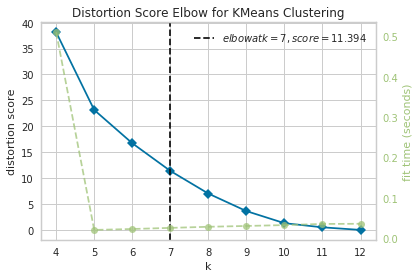

In [66]:
downtown_bubbletea_clustering = final_count[['Bubbletea Shops Count', 'Chinese Related Shops Count']]
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,13))
visualizer.fit(downtown_bubbletea_clustering)
visualizer.show()

In [67]:
# set number of clusters
kclusters = 7

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(downtown_bubbletea_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([4, 6, 0, 5, 2, 0, 1, 3, 0, 0, 5, 5, 0, 0, 0, 0, 0, 0, 0],
      dtype=int32)

In [69]:
# add clustering labels
final_count.insert(0, 'Cluster Labels', kmeans.labels_)

#downtown_merged = downtown_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#downtown_merged = downtown_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

,Cluster Labels,Chinese Related Shops Count,Latitude_x,Longitude_x,Bubbletea Shops Count,Latitude_y,Longitude_y
Central Bay Street,4,7,43.657952,-79.387383,7,43.657952,-79.387383
Church and Wellesley,6,1,43.665860,-79.383160,9,43.665860,-79.383160
"Commerce Court, Victoria Hotel",0,1,43.648198,-79.379817,0,43.648198,-79.379817
"First Canadian Place, Underground city",5,2,43.648429,-79.382280,2,43.648429,-79.382280
"Garden District, Ryerson",2,4,43.657162,-79.378937,8,43.657162,-79.378937
"Harbourfront East, Union Station, Toronto Islands",0,1,43.640816,-79.381752,0,43.640816,-79.381752
"Kensington Market, Chinatown, Grange Park",1,18,43.653206,-79.400049,12,43.653206,-79.400049
"Richmond, Adelaide, King",3,6,43.650571,-79.384568,3,43.650571,-79.384568
St. James Town,0,1,43.651494,-79.375418,0,43.651494,-79.375418
"St. James Town, Cabbagetown",0,1,43.667967,-79.367675,0,43.667967,-79.367675


In [76]:
final = final_count[['Cluster Labels', 'Chinese Related Shops Count', 'Bubbletea Shops Count', 'Latitude_x' , 'Longitude_x']]
final.rename(columns={'Latitude_x':'Latitude', 'Longitude_x':'Longitude'},inplace=True)
final

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
Central Bay Street,4,7,7,43.657952,-79.387383
Church and Wellesley,6,1,9,43.665860,-79.383160
"Commerce Court, Victoria Hotel",0,1,0,43.648198,-79.379817
"First Canadian Place, Underground city",5,2,2,43.648429,-79.382280
"Garden District, Ryerson",2,4,8,43.657162,-79.378937
"Harbourfront East, Union Station, Toronto Islands",0,1,0,43.640816,-79.381752
"Kensington Market, Chinatown, Grange Park",1,18,12,43.653206,-79.400049
"Richmond, Adelaide, King",3,6,3,43.650571,-79.384568
St. James Town,0,1,0,43.651494,-79.375418
"St. James Town, Cabbagetown",0,1,0,43.667967,-79.367675


In [96]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(final['Latitude'], final['Longitude'], final.index, final['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [89]:
final.loc[final['Cluster Labels']==0]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
"Commerce Court, Victoria Hotel",0,1,0,43.648198,-79.379817
"Harbourfront East, Union Station, Toronto Islands",0,1,0,43.640816,-79.381752
St. James Town,0,1,0,43.651494,-79.375418
"St. James Town, Cabbagetown",0,1,0,43.667967,-79.367675
"Regent Park, Harbourfront",0,0,1,43.654260,-79.360636
"Queen's Park, Ontario Provincial Government",0,0,2,43.662301,-79.389494
Berczy Park,0,0,0,43.644771,-79.373306
Christie,0,0,0,43.669542,-79.422564
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0,0,0,43.628947,-79.394420
Rosedale,0,0,0,43.679563,-79.377529


In [90]:
final.loc[final['Cluster Labels']==1]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
"Kensington Market, Chinatown, Grange Park",1,18,12,43.653206,-79.400049


In [91]:
final.loc[final['Cluster Labels']==2]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
"Garden District, Ryerson",2,4,8,43.657162,-79.378937


In [92]:
final.loc[final['Cluster Labels']==3]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
"Richmond, Adelaide, King",3,6,3,43.650571,-79.384568


In [93]:
final.loc[final['Cluster Labels']==4]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
Central Bay Street,4,7,7,43.657952,-79.387383


In [94]:
final.loc[final['Cluster Labels']==5]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
"First Canadian Place, Underground city",5,2,2,43.648429,-79.382280
"Toronto Dominion Centre, Design Exchange",5,2,0,43.647177,-79.381576
"University of Toronto, Harbord",5,4,1,43.662696,-79.400049


In [95]:
final.loc[final['Cluster Labels']==6]

,Cluster Labels,Chinese Related Shops Count,Bubbletea Shops Count,Latitude,Longitude
Church and Wellesley,6,1,9,43.66586,-79.38316
